**Imports**

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara

seg_dim = 9

BATCH_SIZE = 4

**Multi-Plot**

In [2]:
ranges = list(zip(np.arange(1, 7000, 300), np.arange(300, 7100, 300)))
ranges = [list(t) for t in ranges]
# ranges[0][0] = 0
# ranges[0][1] = 50

In [3]:
img_path = './ASSR/images/train/'
imgs = {}

i = 0
experiment = 1
range_ = ranges[experiment - 1]

for root, dirs, files in os.walk(img_path):
    for file in files[range_[0]:range_[1]]:
        file_name = file.split('.')[0]
        imgs[file_name] = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
        i += 1

In [4]:
mask_path = './ASSR/gt/train/'
# masks = {}
gt_masks = {}
gt_ranks = {}

for file_name in imgs:
    gt_ranks[file_name] = {}
    
    file = file_name + '.png'
    mask = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # masks[file_name] = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # Separate the mask based on colour
    # masks[file_name] = {}
    gt_masks[file_name] = {}

    # Detect different colours in mask
    # Create histogram
    hist = cv2.calcHist([mask], [0], None, [256], [0, 256])

    # Show non-zero values and extract intensity values at that freq
    non_zero = np.nonzero(hist)
    x = non_zero[0][1:]

    # Separate mask into regions which match the intensity values in x
    for i, intensity in enumerate(reversed(x)):
        # masks[file_name][i] = np.where(mask == intensity, 1, 0)
        gt_masks[file_name][i] = np.where(mask == intensity, 1, 0)
        
        # Calculate ranks based on highest intensity
        gt_ranks[file_name][i] = i + 1


**MASK R-CNN**

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnntf2 import utils
import mrcnntf2.model as modellib
from mrcnntf2 import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = BATCH_SIZE
    GPU_IDS = "0"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GPU_IDS                        0
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [7]:
import tensorflow as tf
import keras
import h5py
print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

2.6.2
2.6.0
3.1.0
Instructions for updating:
Use fn_output_signature instead


In [8]:
# Split the images into batches
image_batches = [list(imgs.values())[i:i+BATCH_SIZE] for i in range(0, len(imgs), BATCH_SIZE)]


masks = {}
i = 0

for batch in image_batches:
    # Run detection for the current batch
    results = model.detect(batch, verbose=0)
    
    # Process the results for the batch
    for result in results:
        file_name = list(imgs.keys())[i]
        
        # Visualize results for the current image in the batch
        r = result
        # visualize.display_instances(imgs[file_name], r['rois'], r['masks'], r['class_ids'], 
        #                             class_names, r['scores'])

        masks[file_name] = {}

        for j in range(len(r['class_ids'])):
            masks[file_name][j] = np.array(r['masks'][:, :, j], dtype=np.uint8) * 255


        i += 1


    # Print progress
    print(f'Batch {i // BATCH_SIZE} of {len(imgs) // BATCH_SIZE} complete')

Batch 1 of 74 complete
Batch 2 of 74 complete
Batch 3 of 74 complete
Batch 4 of 74 complete
Batch 5 of 74 complete
Batch 6 of 74 complete
Batch 7 of 74 complete
Batch 8 of 74 complete
Batch 9 of 74 complete
Batch 10 of 74 complete
Batch 11 of 74 complete
Batch 12 of 74 complete
Batch 13 of 74 complete
Batch 14 of 74 complete
Batch 15 of 74 complete
Batch 16 of 74 complete
Batch 17 of 74 complete
Batch 18 of 74 complete
Batch 19 of 74 complete
Batch 20 of 74 complete
Batch 21 of 74 complete
Batch 22 of 74 complete
Batch 23 of 74 complete
Batch 24 of 74 complete
Batch 25 of 74 complete
Batch 26 of 74 complete
Batch 27 of 74 complete
Batch 28 of 74 complete
Batch 29 of 74 complete
Batch 30 of 74 complete
Batch 31 of 74 complete
Batch 32 of 74 complete
Batch 33 of 74 complete
Batch 34 of 74 complete
Batch 35 of 74 complete
Batch 36 of 74 complete
Batch 37 of 74 complete
Batch 38 of 74 complete
Batch 39 of 74 complete
Batch 40 of 74 complete
Batch 41 of 74 complete
Batch 42 of 74 complete
B

AssertionError: len(images) must be equal to BATCH_SIZE

In [9]:
# Match masks generated to Mask RCNN to ground truth masks

masks_valid = {}
gt_masks_valid = {}
gt_ranks_valid = {}

for file_name in masks:
    masks_valid[file_name] = {}
    gt_masks_valid[file_name] = {}
    gt_ranks_valid[file_name] = {}
    
    for mask in masks[file_name]:
        best_iou = 0
        for gt_mask in gt_masks[file_name]:
            # Calculate IoU
            intersection = np.logical_and(masks[file_name][mask], gt_masks[file_name][gt_mask])
            union = np.logical_or(masks[file_name][mask], gt_masks[file_name][gt_mask])
            iou_score = np.sum(intersection) / np.sum(union)

            if iou_score > 0.6 and iou_score > best_iou:
                best_iou = iou_score
                masks_valid[file_name][mask] = masks[file_name][mask]
                gt_masks_valid[file_name][mask] = gt_masks[file_name][gt_mask]
                gt_ranks_valid[file_name][mask] = gt_ranks[file_name][gt_mask]

        # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        # ax[0].imshow(masks_valid[file_name][mask], cmap='gray')
        # ax[1].imshow(gt_masks_valid[file_name][mask], cmap='gray')
        # plt.show()


# Delete empty masks


In [14]:
masks = masks_valid
gt_masks = gt_masks_valid
gt_ranks = gt_ranks_valid

In [21]:
# Save to ;.h5
import h5py

with h5py.File('masks.h5', 'w') as hf:
    for file_name in masks:
        for mask in masks[file_name]:
            hf.create_dataset(f'{file_name}/{mask}', data=masks[file_name][mask])

with h5py.File('gt_masks.h5', 'w') as hf:
    for file_name in gt_masks:
        for mask in gt_masks[file_name]:
            hf.create_dataset(f'{file_name}/{mask}', data=gt_masks[file_name][mask])

with h5py.File('gt_ranks.h5', 'w') as hf:
    for file_name in gt_ranks:
        gt_ranks[file_name] = np.array(list(gt_ranks[file_name].values()))
        hf.create_dataset(f'{file_name}', data=gt_ranks[file_name])

In [4]:
# Load from .h5
import h5py

masks = {}

with h5py.File('masks.h5', 'r') as hf:
    for file_name in hf:
        masks[file_name] = {}
        for mask in hf[file_name]:
            masks[file_name][mask] = hf[f'{file_name}/{mask}'][:]

gt_masks = {}

with h5py.File('gt_masks.h5', 'r') as hf:
    for file_name in hf:
        gt_masks[file_name] = {}
        for mask in hf[file_name]:
            gt_masks[file_name][mask] = hf[f'{file_name}/{mask}'][:]

gt_ranks = {}

with h5py.File('gt_ranks.h5', 'r') as hf:
    for file_name in hf:
        gt_ranks[file_name] = hf[file_name][:]

        # Convert list into dict with keys as integers
        gt_ranks[file_name] = {i: rank for i, rank in enumerate(gt_ranks[file_name])}

**Saliency Maps/Heatmaps/Rankings**

In [5]:
from time import time
import deepgaze_pytorch

plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

generators = ['deepgaze']

BATCH_SIZE = 8

DEVICE = 'cuda'  # Use GPU if available
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

# Split the images into batches with the image names as keys and the images as values
image_batches = [{k: imgs[k] for k in list(imgs.keys())[i:i+BATCH_SIZE]} for i in range(0, len(imgs), BATCH_SIZE)]

seg_dim = 9
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

for c, batch in enumerate(image_batches):
    start = time()

    for im in batch:
        if im not in saliency_maps:
            saliency_maps[im] = {}
            sara_heatmaps[im] = {}
            sara_lists[im] = {}

    for generator in generators:
        temp_saliency_maps = sara.return_saliency_batch(batch.values(), generator=generator, deepgaze_model=model, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)

        for i in range(len(temp_saliency_maps)):
            temp_saliency_maps[i] = temp_saliency_maps[i] * 255
            temp_saliency_maps[i] = temp_saliency_maps[i] // 8
        
        
        
    sara.reset()

    for i, im in enumerate(batch):
        # plt.figure()
        saliency_maps[im][generator] = temp_saliency_maps[i]
        sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(cv2.cvtColor(imgs[im].copy(), cv2.COLOR_RGB2BGR), seg_dim, saliency_map=saliency_maps[im][generator])
        # plt.subplot(121)
        # plt.imshow(saliency_maps[im][generator], cmap='gray')
        # plt.subplot(122)
        # plt.imshow(cv2.cvtColor(sara_heatmaps[im][generator], cv2.COLOR_BGR2RGB))
        # plt.show()
        # sara.reset()

    print(f'Time for batch {c + 1}: {time() - start} seconds')

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/optimisations/saliency-generator/saraRC1.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  image_batch = torch.tensor([img.transpose(2, 0, 1) for img in images]).to(DEVICE)


Time for batch 1: 2.091621160507202 seconds
Time for batch 2: 2.040437936782837 seconds
Time for batch 3: 2.0845491886138916 seconds
Time for batch 4: 2.120485305786133 seconds
Time for batch 5: 2.107020378112793 seconds
Time for batch 6: 2.091219663619995 seconds
Time for batch 7: 2.1094467639923096 seconds
Time for batch 8: 2.105173110961914 seconds
Time for batch 9: 2.1426689624786377 seconds
Time for batch 10: 2.120084047317505 seconds
Time for batch 11: 2.1147849559783936 seconds
Time for batch 12: 2.1900837421417236 seconds
Time for batch 13: 2.2075488567352295 seconds
Time for batch 14: 2.141451835632324 seconds
Time for batch 15: 2.179631471633911 seconds
Time for batch 16: 2.140202045440674 seconds
Time for batch 17: 2.1792008876800537 seconds
Time for batch 18: 2.1985280513763428 seconds
Time for batch 19: 2.132585048675537 seconds
Time for batch 20: 2.1482930183410645 seconds
Time for batch 21: 2.164198160171509 seconds
Time for batch 22: 2.181788921356201 seconds
Time for b

<Figure size 1440x720 with 0 Axes>

In [6]:
# Save to .h5
import h5py

with h5py.File('saliency_maps.h5', 'w') as hf:
    for file_name in saliency_maps:
        for generator in saliency_maps[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=saliency_maps[file_name][generator])

with h5py.File('sara_heatmaps.h5', 'w') as hf:
    for file_name in sara_heatmaps:
        for generator in sara_heatmaps[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=sara_heatmaps[file_name][generator])

with h5py.File('sara_lists.h5', 'w') as hf:
    for file_name in sara_lists:
        for generator in sara_lists[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=sara_lists[file_name][generator])

In [7]:
# Load from .h5
import h5py

saliency_maps = {}

with h5py.File('saliency_maps.h5', 'r') as hf:
    for file_name in hf:
        saliency_maps[file_name] = {}
        for generator in hf[file_name]:
            saliency_maps[file_name][generator] = hf[f'{file_name}/{generator}'][:]

sara_heatmaps = {}

with h5py.File('sara_heatmaps.h5', 'r') as hf:
    for file_name in hf:
        sara_heatmaps[file_name] = {}
        for generator in hf[file_name]:
            sara_heatmaps[file_name][generator] = hf[f'{file_name}/{generator}'][:]

sara_lists = {}

with h5py.File('sara_lists.h5', 'r') as hf:
    for file_name in hf:
        sara_lists[file_name] = {}
        for generator in hf[file_name]:
            sara_lists[file_name][generator] = hf[f'{file_name}/{generator}'][:]

**<h2>Mask Ranking</h2>**

In [8]:
T = 0.001

In [9]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

In [10]:
# For each segment, check which mask falls under that segment using MRn = rank(Gi); (Gi interesect Mn) > T
mask_segments = {}

for sara_list in sara_lists:
    for segment in sara_lists[sara_list]['deepgaze']:
        if sara_list not in mask_segments:
            mask_segments[sara_list] = {}

        # Convert index to coordinates, extract segment from heatmap
        shape = sara_heatmaps[sara_list]['deepgaze'].shape[0:2]
        x1, y1, x2, y2 = index_to_coordinates(segment[6], seg_dim, shape)
        # print(x1, y1, x2, y2)

        for m in masks[sara_list]:
            if m not in mask_segments[sara_list]:
                mask_segments[sara_list][m] = []

            # Extract mask from masks
            mask = masks[sara_list][m][y1:y2, x1:x2]

            # Calculate intersection over union
            intersection = np.sum(mask > 0)
            union = np.sum(mask > 0) + np.sum(mask == 0)

            iou = intersection / union

            # print('Segment: ', segment[5], 'Mask: ', m, 'IoU: ', iou)

            if iou > T:
                # index, rank, score
                # print(segment)
                mask_segments[sara_list][m].append((segment[6], segment[0], segment[1]))
                # print(mask_segments)

KeyError: 'COCO_train2014_000000111492'

In [11]:
# For each mask, find the segment with the lowest rank
mask_segments_min = {}

for sara_list in mask_segments:
    for m in mask_segments[sara_list]:
        # mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])[0]
        if sara_list not in mask_segments_min:
            mask_segments_min[sara_list] = {}
        
        mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])

mask_segments_min

{'COCO_train2014_000000001523': {'0': (41.0, 0.0, 560959.6604442507),
  '1': (33.0, 17.0, 587874.8152523325),
  '2': (26.0, 58.0, 624208.0656858506)},
 'COCO_train2014_000000002007': {'0': (41.0, 18.0, 587618.5383568599),
  '3': (32.0, 56.0, 630488.8860645775),
  '4': (33.0, 34.0, 629018.8137635189),
  '5': (44.0, 16.0, 576522.9970223901)},
 'COCO_train2014_000000002860': {'0': (38.0, 5.0, 600092.5325757252),
  '1': (25.0, 37.0, 722074.3367012348),
  '4': (32.0, 15.0, 665771.3199810801)},
 'COCO_train2014_000000003478': {'0': (12.0, 14.0, 766224.7578265365),
  '3': (47.0, 1.0, 568985.1656682213),
  '5': (14.0, 11.0, 754739.1989890109),
  '6': (31.0, 21.0, 649544.9453996652)},
 'COCO_train2014_000000006710': {'0': (57.0, 0.0, 498351.9637787245),
  '6': (24.0, 7.0, 691009.5758637801)},
 'COCO_train2014_000000011426': {'0': (51.0, 0.0, 540687.7128464859),
  '11': (21.0, 28.0, 704945.8633320649),
  '17': (15.0, 10.0, 746279.4480656823),
  '3': (26.0, 48.0, 680224.3551182672),
  '7': (12.0,

In [12]:
mask_ranks = {}

for sara_list in mask_segments_min:
    mask_ranks[sara_list] = {}
    # Extract the ranks and sort them by the third value in each tuple
    sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

    for i in range(len(sorted_ranks)):
        mask_ranks[sara_list][sorted_ranks[i][0]] = i

    # Sort mask_ranks[sara_list] by object
    mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}

In [13]:
mask_ranks

{'COCO_train2014_000000001523': {'0': 0, '1': 1, '2': 2},
 'COCO_train2014_000000002007': {'0': 1, '3': 3, '4': 2, '5': 0},
 'COCO_train2014_000000002860': {'0': 0, '1': 2, '4': 1},
 'COCO_train2014_000000003478': {'0': 2, '3': 0, '5': 1, '6': 3},
 'COCO_train2014_000000006710': {'0': 0, '6': 1},
 'COCO_train2014_000000011426': {'0': 0, '11': 3, '17': 1, '3': 4, '7': 2},
 'COCO_train2014_000000013603': {'0': 2, '1': 1, '2': 0, '8': 3},
 'COCO_train2014_000000013720': {'0': 4, '1': 1, '4': 3, '6': 2, '7': 0},
 'COCO_train2014_000000014253': {'0': 1, '1': 0, '3': 3, '4': 2},
 'COCO_train2014_000000014886': {'0': 0, '3': 1},
 'COCO_train2014_000000015427': {'0': 2, '1': 1, '2': 0},
 'COCO_train2014_000000022014': {'0': 2, '1': 3, '3': 0, '6': 1},
 'COCO_train2014_000000023098': {'0': 0, '1': 3, '2': 2, '3': 1},
 'COCO_train2014_000000024042': {'0': 1, '1': 0, '2': 2, '4': 3},
 'COCO_train2014_000000024912': {'0': 0},
 'COCO_train2014_000000025167': {'0': 0},
 'COCO_train2014_000000029801'

Image: COCO_train2014_000000371608, Mask: 0, Rank: 1, Ground Truth: 2


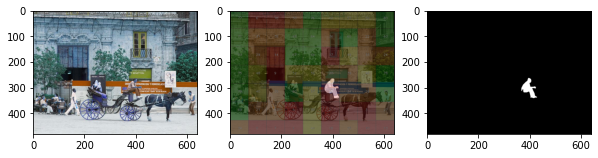

Image: COCO_train2014_000000371608, Mask: 1, Rank: 4, Ground Truth: 1


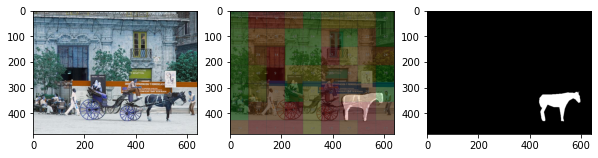

Image: COCO_train2014_000000371608, Mask: 2, Rank: 2, Ground Truth: 5


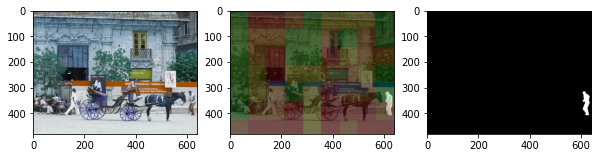

Image: COCO_train2014_000000371608, Mask: 3, Rank: 3, Ground Truth: 4


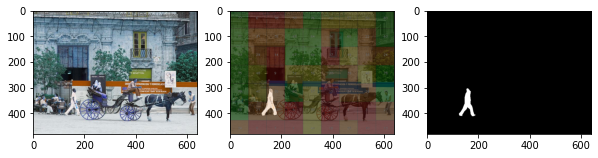

Image: COCO_train2014_000000530869, Mask: 0, Rank: 2, Ground Truth: 1


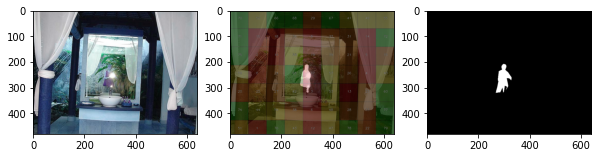

Image: COCO_train2014_000000530869, Mask: 1, Rank: 1, Ground Truth: 2


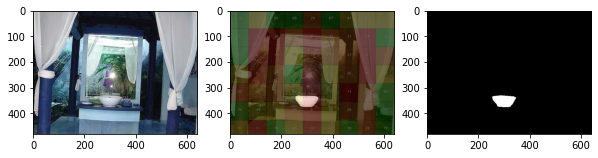

Image: COCO_train2014_000000491492, Mask: 1, Rank: 1, Ground Truth: 3


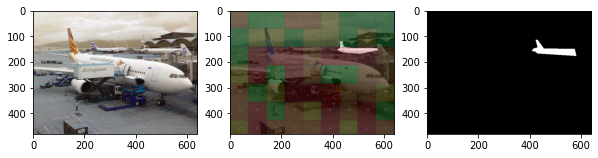

Image: COCO_train2014_000000491492, Mask: 2, Rank: 3, Ground Truth: 4


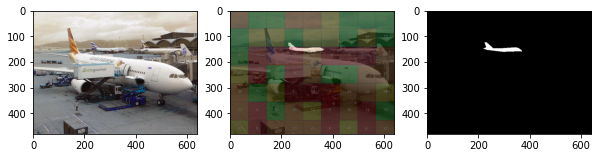

Image: COCO_train2014_000000491492, Mask: 3, Rank: 2, Ground Truth: 1


KeyboardInterrupt: 

In [ ]:
# Find the ith key in imgs, display the image, its sara_heatmap, its masks, their ranks and the ground truth. Multiple masks for the same img should be shown on the same plot
i = 0

for sara_list in mask_ranks:
    for m in mask_ranks[sara_list]:
        if mask_ranks[sara_list][m] != gt_ranks[sara_list][m]:
            print(f'Image: {sara_list}, Mask: {m}, Rank: {mask_ranks[sara_list][m]}, Ground Truth: {gt_ranks[sara_list][m]}')
            fig, ax = plt.subplots(1, 3, figsize=(10, 10))
            ax[0].imshow(cv2.cvtColor(imgs[sara_list], cv2.COLOR_RGB2BGR))
            ax[1].imshow(cv2.cvtColor(sara_heatmaps[sara_list]['deepgaze'], cv2.COLOR_BGR2RGB))
            ax[1].imshow(masks[sara_list][m], cmap='gray', alpha=0.5)
            ax[2].imshow(gt_masks[sara_list][m], cmap='gray')
            plt.show()
            i += 1

**<h2>Spearman Correlation (Metric for Ranks)</h2>**

Average SPR: 0.4432743345094895


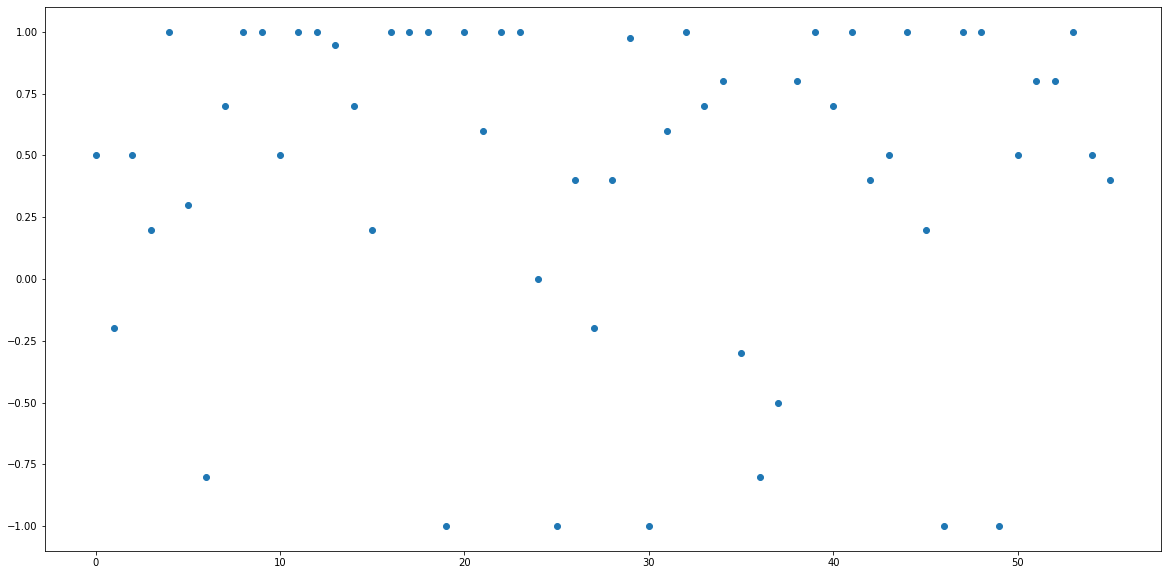

In [19]:
import scipy.stats as sc

all_spr = []

for sara_list in mask_ranks:
    # print(f'PR: {list(mask_ranks[sara_list].values())}\nGT: {list(gt_ranks[sara_list].values())}')
    spr = sc.spearmanr(list(mask_ranks[sara_list].values()), list(gt_ranks[sara_list].values()))
    if not np.isnan(spr.correlation):
        all_spr.append(spr.correlation)
        # print(f'SPR: {spr.correlation}')

print(f'Average SPR: {np.mean(all_spr)}')

# Plot sprs
plt.figure()
plt.plot(all_spr, marker='o', linestyle='None')
plt.show()


In [47]:
# Find cases of lowest correlation and plot them
# smallest arg
sprs = np.array(all_spr)
smallest = np.argsort(sprs)[-5:-1]



In [48]:
indices = list(mask_ranks.keys())
smallest_indices = [indices[i] for i in smallest]

Ranks:  {'0': 0, '2': 1, '3': 4, '5': 2, '9': 3}
GT Ranks:  {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
Ranks:  {'0': 2, '1': 1, '2': 0, '4': 3}
GT Ranks:  {0: 1, 1: 2, 2: 3, 3: 4}
Ranks:  {'0': 2, '1': 0, '4': 1, '7': 3}
GT Ranks:  {0: 4, 1: 2, 2: 1, 3: 3}
Ranks:  {'0': 0, '1': 1, '2': 2, '4': 3}
GT Ranks:  {0: 1, 1: 2, 2: 4, 3: 5}


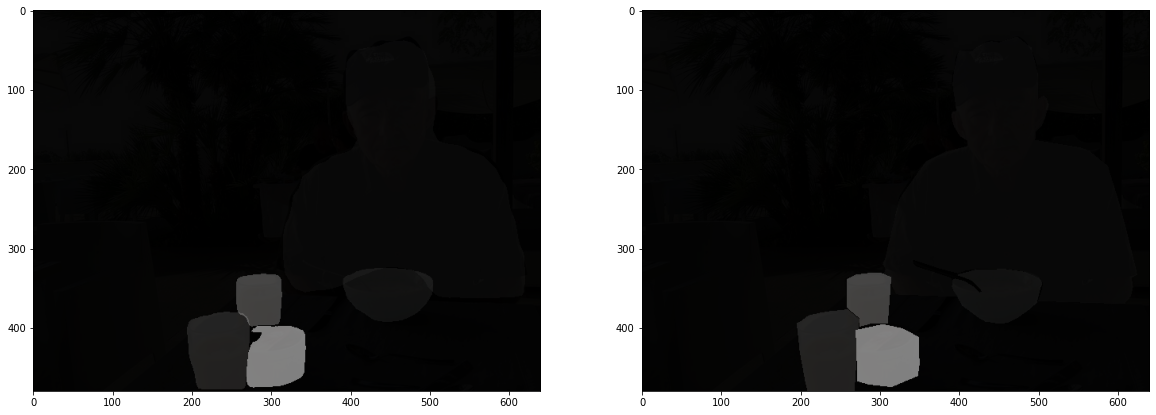

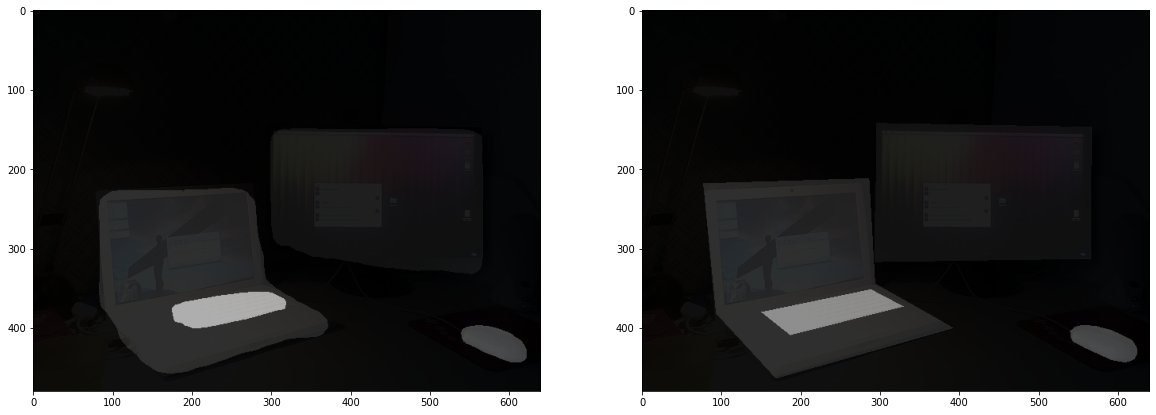

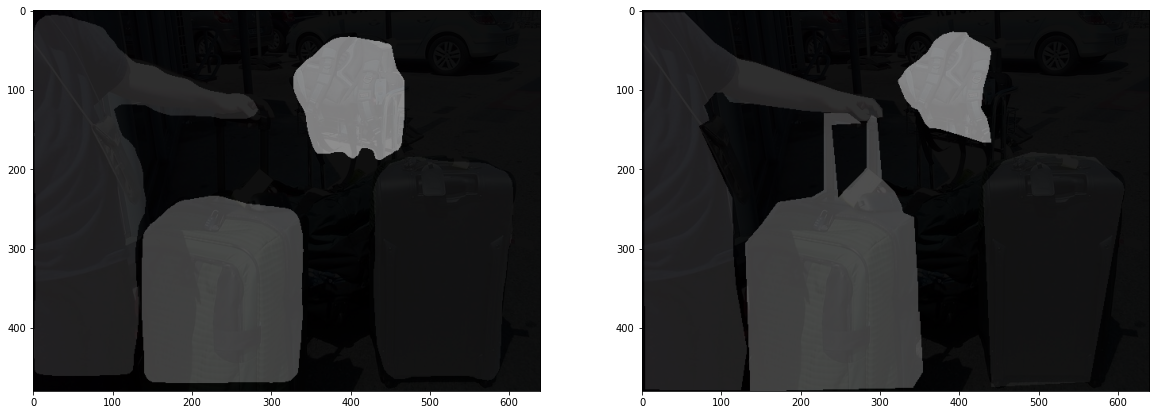

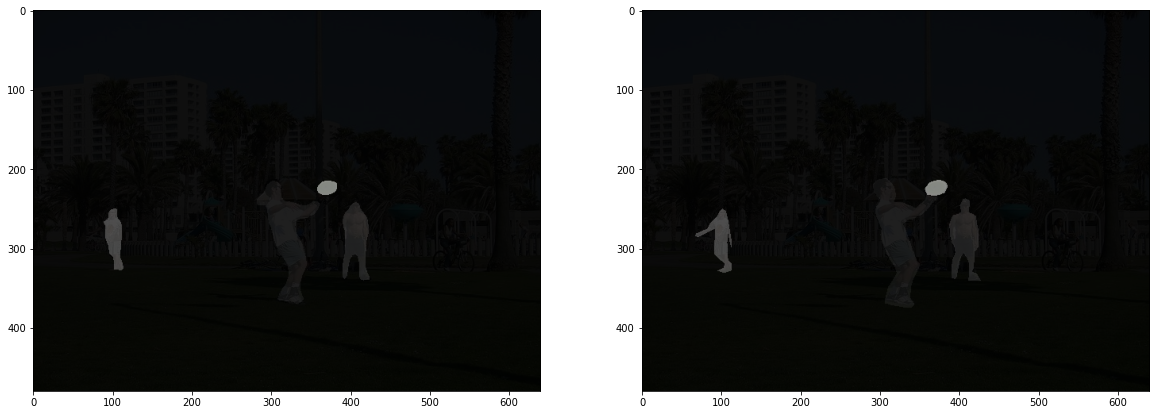

In [49]:
for index in smallest_indices:
    plt.figure()
    plt.subplot(121)
    # Plot image
    plt.imshow(imgs[index])

    # Show masks
    for mask in masks[index]:
        plt.imshow(masks[index][mask], cmap='gray', alpha=0.5)

    # Print ranks
    print('Ranks: ', mask_ranks[index])

    plt.subplot(122)
    plt.imshow(imgs[index])


    # Show ground truth
    for mask in gt_masks[index]:
        plt.imshow(gt_masks[index][mask], cmap='gray', alpha=0.5)

    # Print ranks
    print('GT Ranks: ', gt_ranks[index])
    


**<h2>Normalizing Spearman Correlation</h2>**

In [44]:
def get_norm_spr(spr_value):
    #       m - r_min
    # m -> ---------------- x (t_max - t_min) + t_min
    #       r_max - r_min
    #
    # m = measure value
    # r_min = min range of measurement
    # r_max = max range of measurement
    # t_min = min range of desired scale
    # t_max = max range of desired scale

    r_min = -1
    r_max = 1

    norm_spr = (spr_value - r_min) / (r_max - r_min)

    return norm_spr

In [46]:
norm_spr = get_norm_spr(spr.correlation)
print(norm_spr)

0.7


**<h2>Mean Absolute Error</h2>**

In [ ]:
def mae(pred, gt):
    return np.mean(np.abs(pred - gt))

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


Average /mae: 2.55880244140625


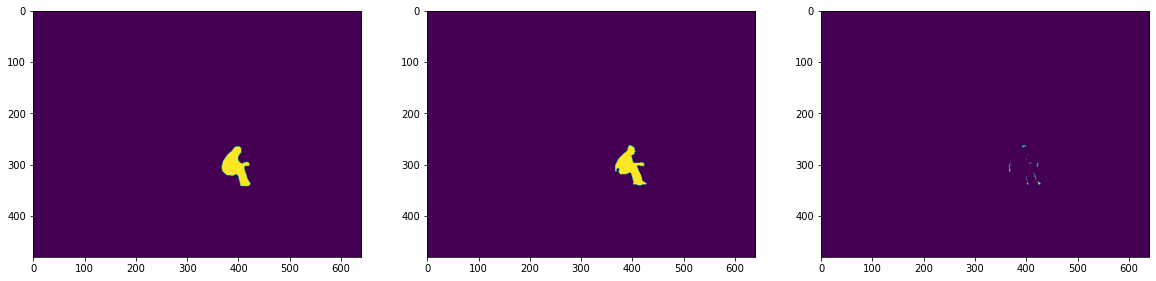

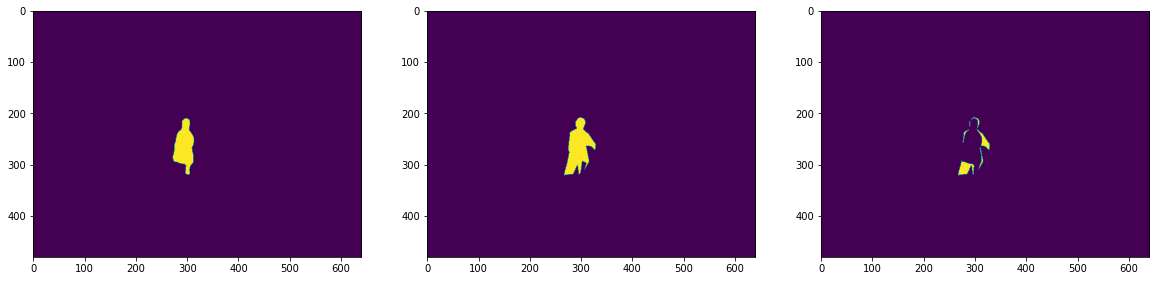

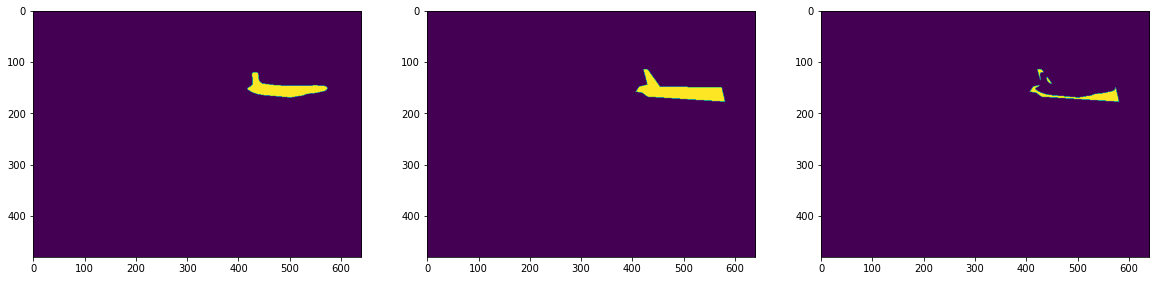

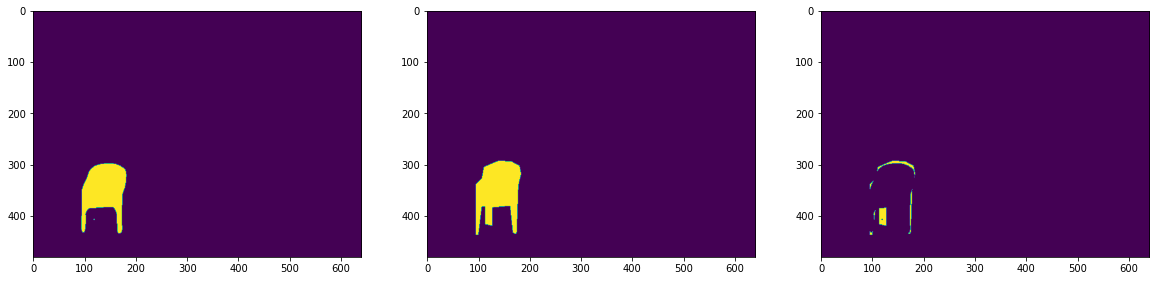

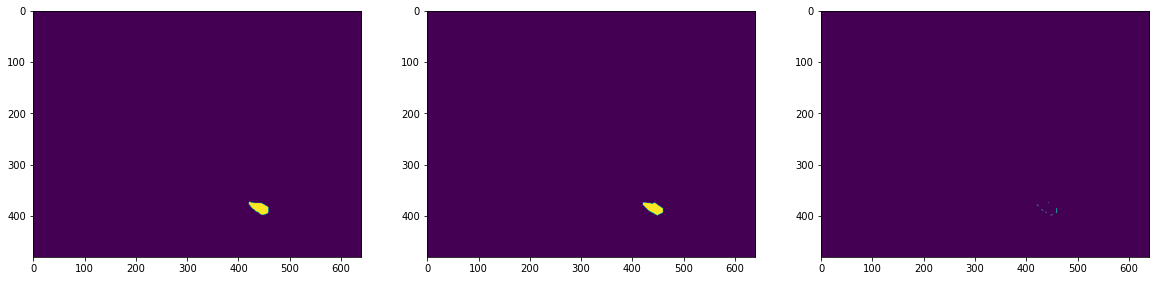

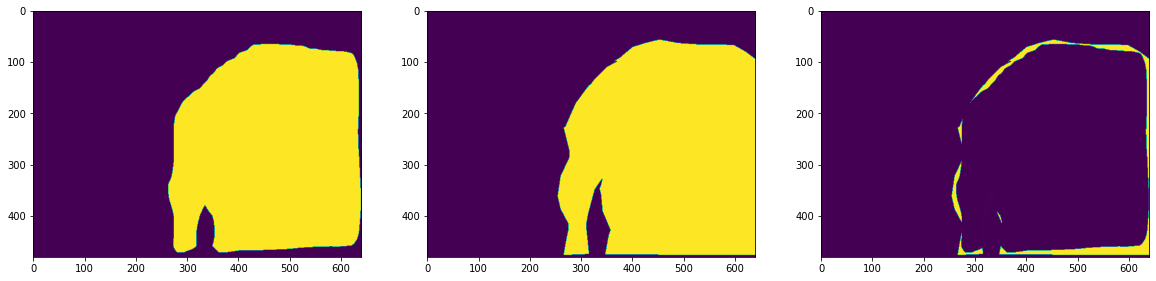

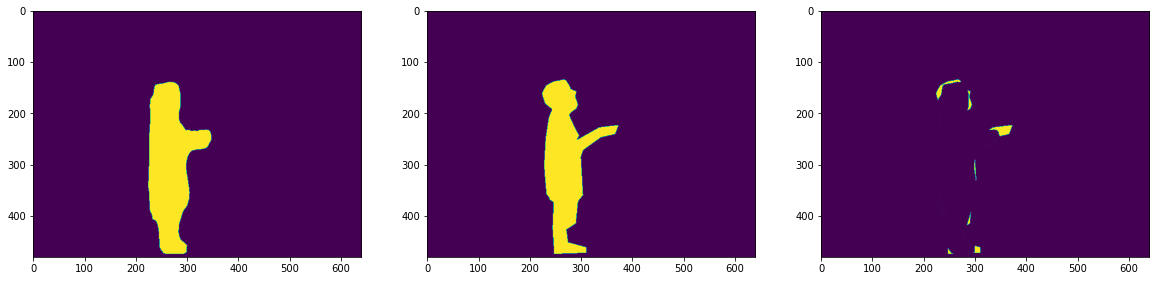

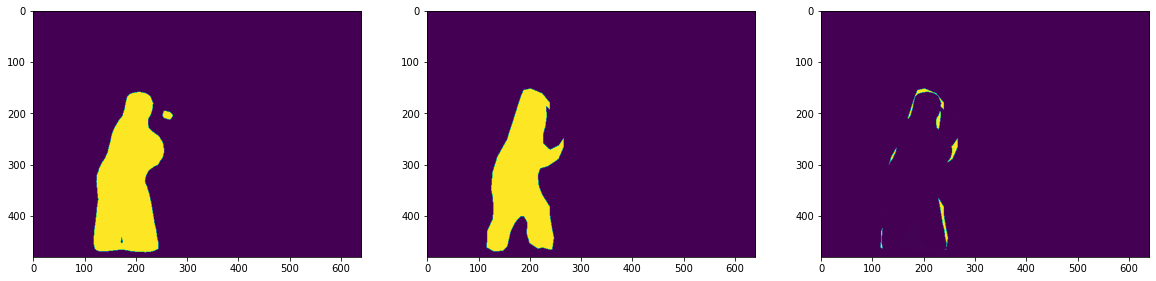

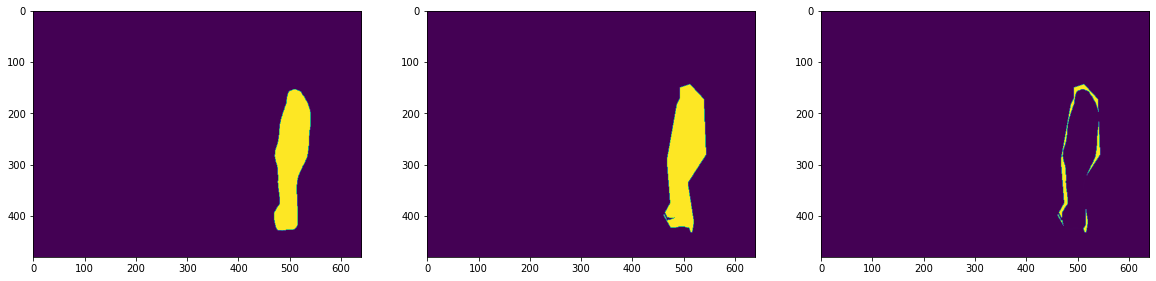

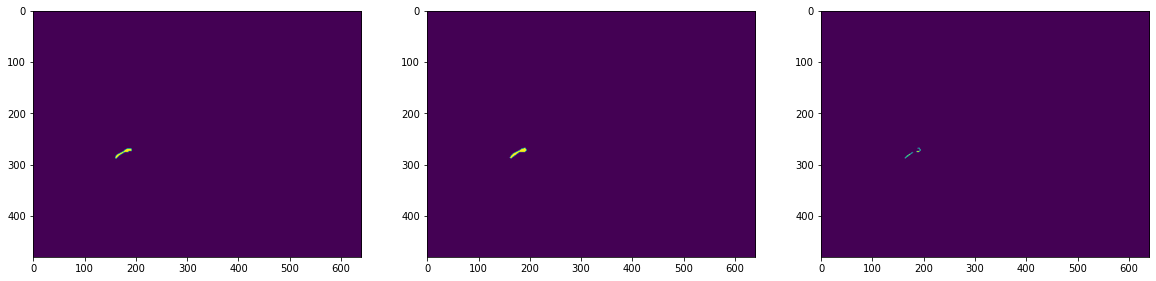

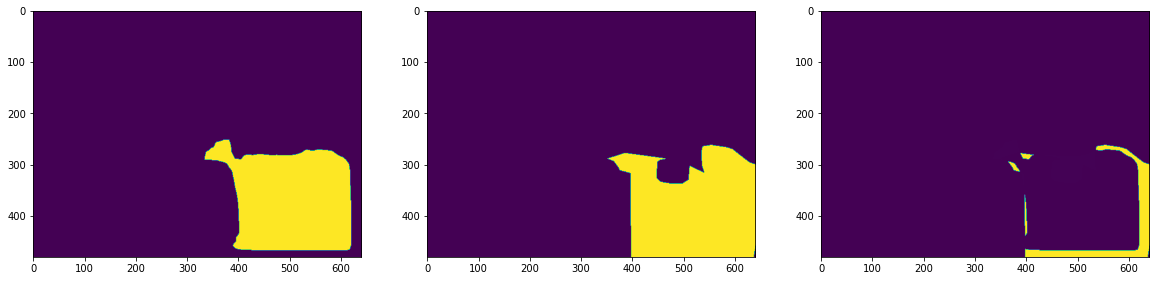

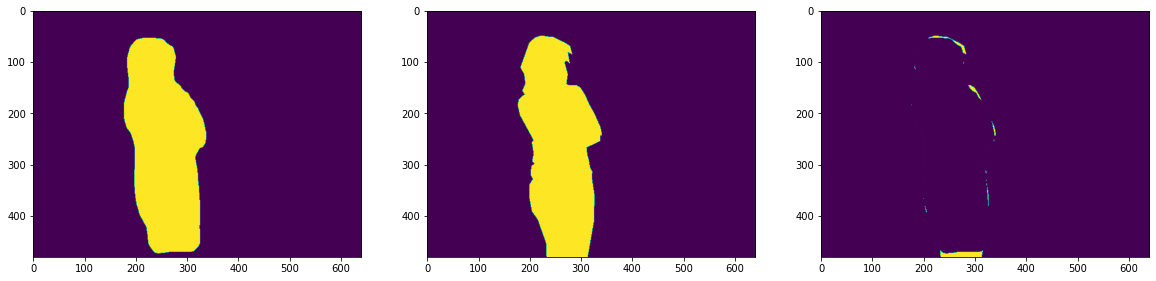

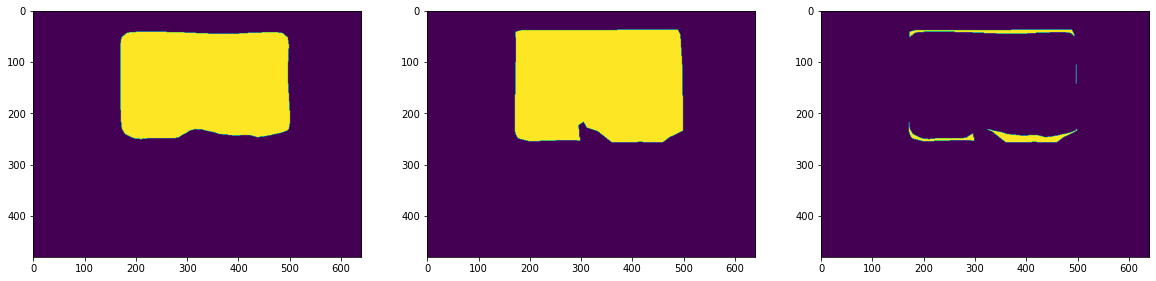

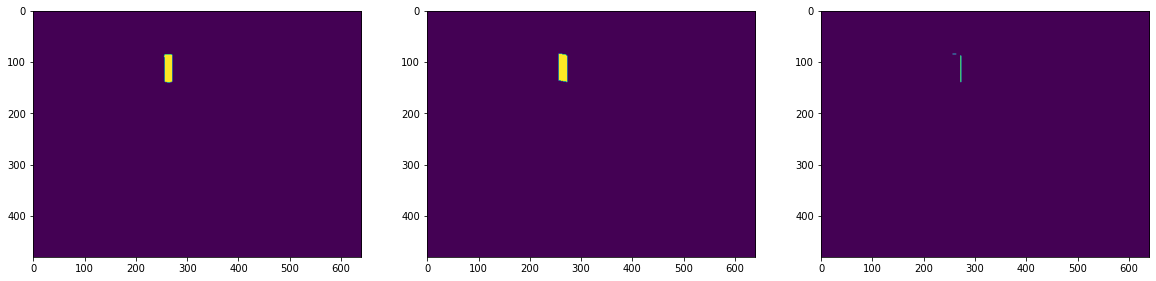

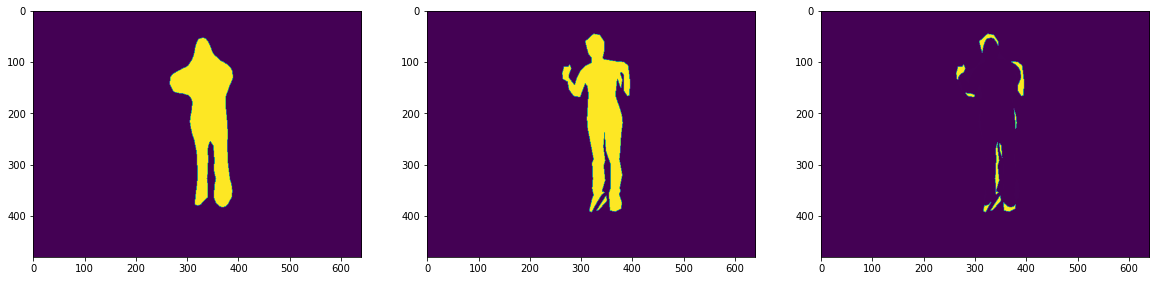

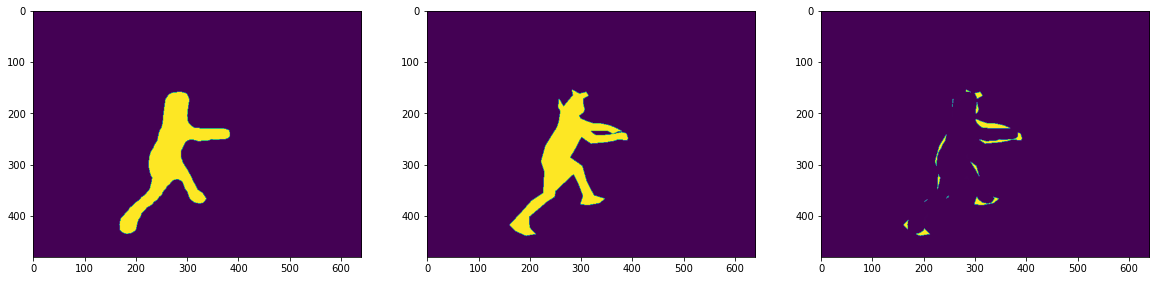

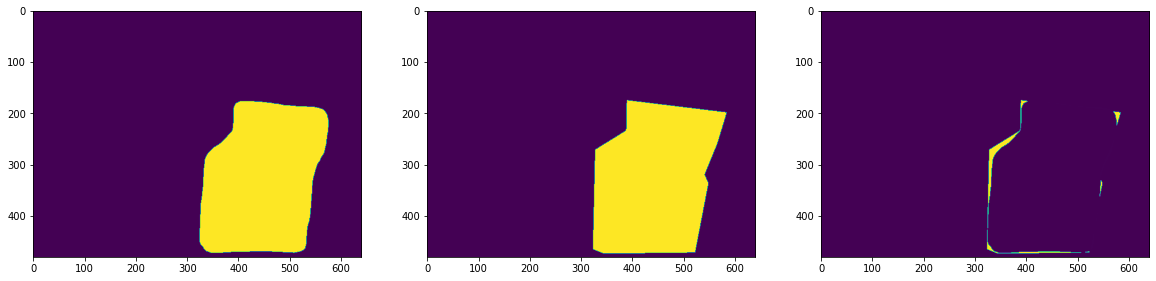

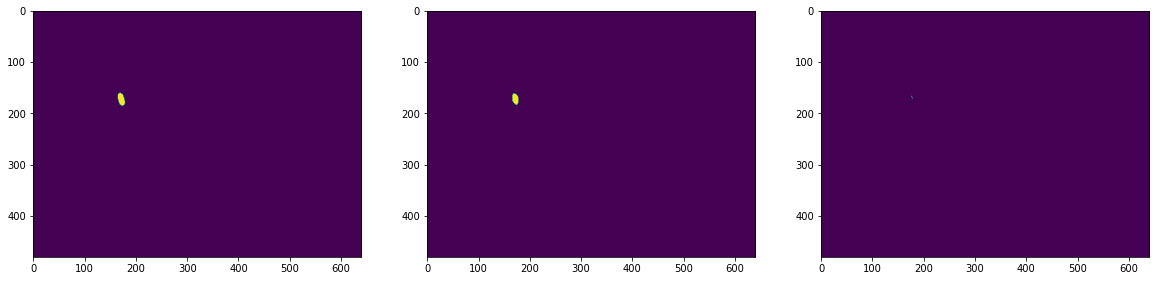

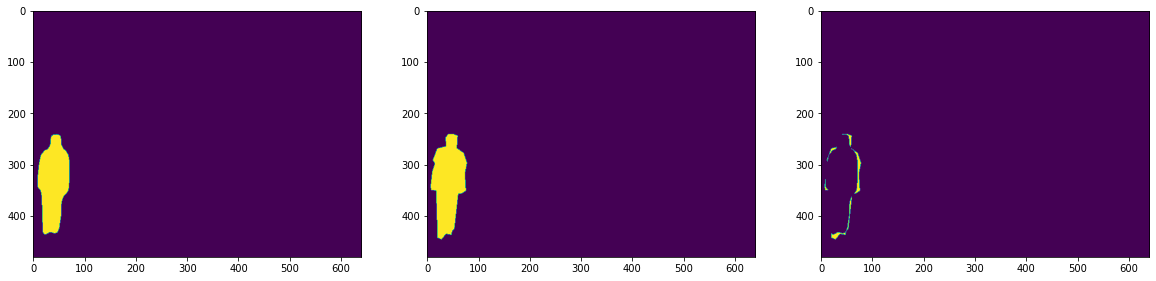

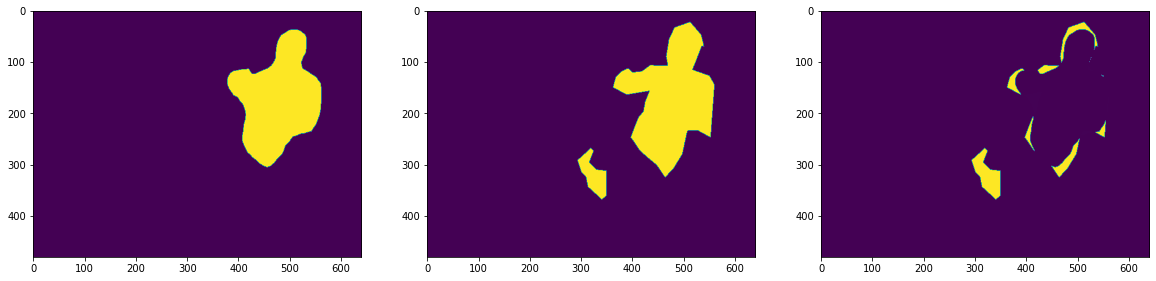

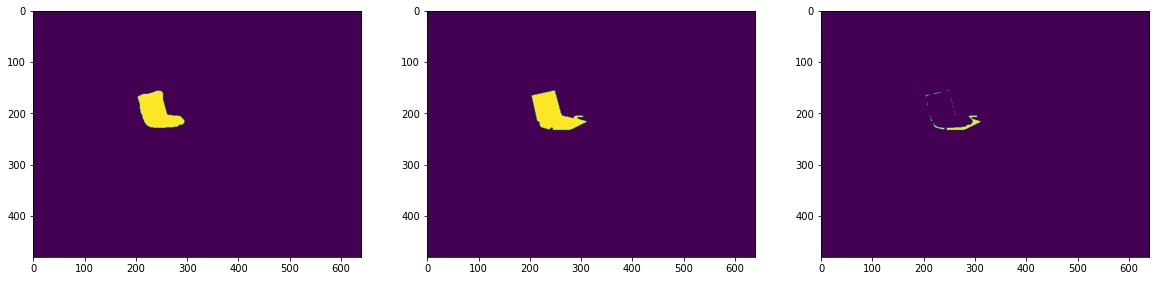

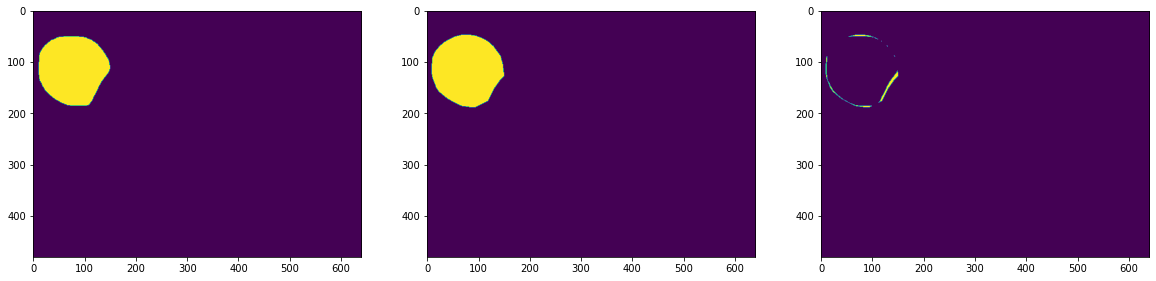

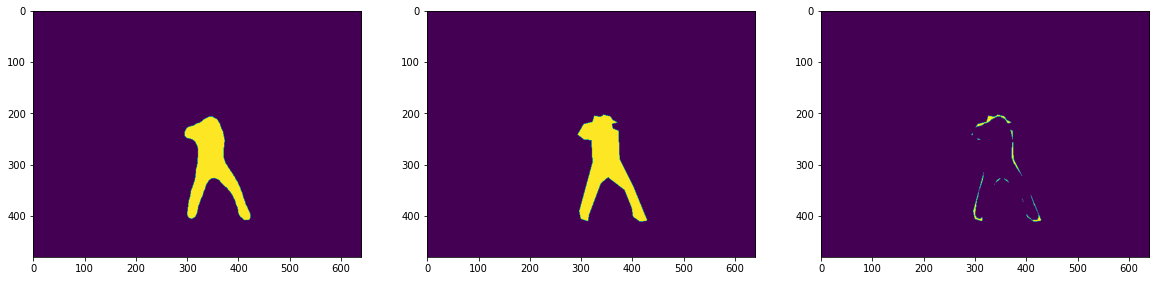

Error in callback <function flush_figures at 0x7f4bc00d3048> (for post_execute):


KeyboardInterrupt: 

In [ ]:
all_mae = 0

for sara_list in masks:
    for mask in masks[sara_list]:
        # print(masks[sara_list][mask] - gt_masks[sara_list][mask])
        pred = masks[sara_list][mask]
        pred = np.array(pred, dtype=np.uint8)
        pred = cv2.threshold(pred, 0.5, 1, cv2.THRESH_BINARY)[1]

        gt = gt_masks[sara_list][mask]
        gt = np.array(gt, dtype=np.uint8)
        gt = cv2.threshold(gt, 0.5, 1, cv2.THRESH_BINARY)[1]

        temp_mae = mae(pred, gt)
        plt.figure()
        plt.subplot(131)
        plt.imshow(pred)
        plt.subplot(132)
        plt.imshow(gt)
        plt.subplot(133)
        plt.imshow(pred - gt)
        all_mae += temp_mae
        # print()
        break

print(f'Average /mae: {all_mae / len(masks)}')